# Домашнее задание №1 - Применение методов NLP


В этом домашнем задании мы будем работать с данными из сорневнования: 
[Toxic comment classification challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)
  
  
В задании небходимо по тексту комментария определить веротяности следующих категорий:
- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

Как и в соревновании мы везде будем использовать метрику ROC AUC для валидации

_Обратите внимание, что каждый комментарий может иметь несколько меток разных классов_

### Что нужно сделать? 

1. Подготовка __[10%]__:
    - Скачайте данные, проведите первоначальные EDA: баланс классов, пересечение классов и т.д. 
    

In [118]:
import pandas as pd 
import numpy as np
%matplotlib inline

In [119]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [120]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [121]:
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [122]:
count_classes = train.iloc[:,2:].sum(axis = 1)
train['clean'] = (count_classes == 0)
print("Total comments = ", len(train))
print("Total clean comments = ", train['clean'].sum())
print("Total tags = ", count_classes.sum())

Total comments =  159571
Total clean comments =  143346
Total tags =  35098


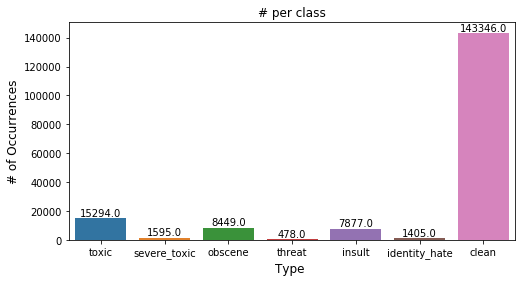

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

classes=train.iloc[:,2:].sum()
plt.figure(figsize=(8,4))
ax= sns.barplot(classes.index, classes.values)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
rects = ax.patches
labels = classes.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

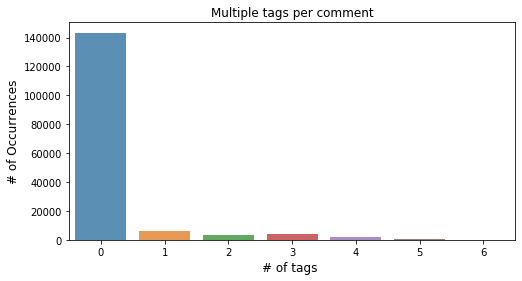

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
dtype: int64


In [124]:
x=count_classes.value_counts()

plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)
plt.show()
print(x)

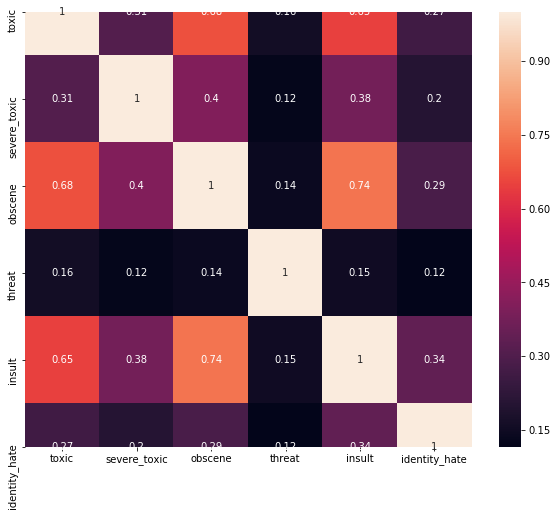

In [125]:
temp_df=train.iloc[:,2:-1]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True);

In [126]:
main_col="toxic"
corr_mats=[]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    array_conf_matrix = np.array(confusion_matrix.values)
    df_conf_matrix = pd.DataFrame(array_conf_matrix)
    corr_mats.append(df_conf_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])
out.index.name = 'toxic'

out

severe_toxic       obscene        threat       insult        \
                 0     1       0     1       0    1       0     1   
toxic                                                               
0           144277     0  143754   523  144248   29  143744   533   
1            13699  1595    7368  7926   14845  449    7950  7344   

      identity_hate        
                  0     1  
toxic                      
0            144174   103  
1             13992  1302

## Все очень токсичные комментарии - токсичные

# Придумайте и обоснуйте стратегию валидации.
Сделайте предбработку данных. Оцените что требуется делать с символами, заглавными буквами. Проведите лемматизацию или стеминг.

# Сделал Adversarial validation, вроде неплохо сходится с тестом

In [127]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re, string
import time
from scipy.sparse import hstack, vstack

from sklearn.model_selection import StratifiedKFold

In [129]:
def tokenize(s): 
#     global a
#     if a == 0:
#         print(s)
#         a = 1
    return re_tok.sub(r' \1 ', s).split()

In [130]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [131]:
tmp = "explanation why the edits made under my username hardcore metallica fan were reverted? they weren' t vandalisms, just closure on some gas after i voted at new york dolls fac. and please don't remove the template from the talk page since i'm retired now.89.205.38.27"

In [132]:
train['comment_text'][:5]

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

In [146]:
vec = TfidfVectorizer(ngram_range=(1,2), lowercase=True,
               min_df=4, strip_accents='unicode', use_idf=1,
                      smooth_idf=1, sublinear_tf=1)
tmp1 = vec.fit_transform(train['comment_text'][:1000])

In [147]:
# print(tmp1)

In [148]:
print(vec.get_feature_names())

['000', '04', '06', '07', '08', '09', '10', '100', '11', '12', '13', '14', '15', '16', '161', '17', '177', '18', '19', '194', '1px', '1px solid', '1st', '20', '200', '2000', '2004', '2004 utc', '2005', '2005 utc', '2006', '2006 utc', '2007', '2007 utc', '2008', '2010', '2011', '2012', '2013', '2014', '209', '20th', '21', '23', '24', '25', '27', '28', '29', '30', '31', '33', '36', '38', '3rr', '45', '50', '67', '70', '80', '81', '82', '86', '90', 'able', 'able to', 'about', 'about contributing', 'about him', 'about his', 'about it', 'about my', 'about person', 'about that', 'about the', 'about this', 'about what', 'about your', 'above', 'absolutely', 'abusing', 'academic', 'accept', 'accepted', 'accepted as', 'access', 'access to', 'according', 'according to', 'account', 'accounts', 'accurate', 'accusations', 'accused', 'accusing', 'accusing me', 'across', 'across the', 'act', 'action', 'actions', 'actual', 'actually', 'ad', 'ad hominem', 'add', 'add information', 'add the', 'added', 'a

In [46]:
print('\1')




In [20]:
# Tf-idf

# prepare tokenizer
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

# create sparse matrices
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
                      smooth_idf=1, sublinear_tf=1)
train_term_doc = vec.fit_transform(train['comment_text'])
test_term_doc = vec.transform(test['comment_text'])

In [21]:
print(vec.get_feature_names()[:8000])

['!', '! !', '! "', '! #', '! $', '! &', "! '", '! (', '! )', '! *', '! +', '! ,', '! -', '! .', '! /', '! 0', '! 00', '! 01', '! 02', '! 03', '! 04', '! 05', '! 06', '! 07', '! 08', '! 09', '! 1', '! 10', '! 108', '! 11', '! 111', '! 1111', '! 12', '! 122', '! 124', '! 13', '! 137', '! 14', '! 141', '! 142', '! 15', '! 16', '! 17', '! 172', '! 173', '! 18', '! 184', '! 188', '! 19', '! 192', '! 195', '! 198', '! 199', '! 2', '! 20', '! 203', '! 204', '! 207', '! 208', '! 209', '! 21', '! 211', '! 212', '! 216', '! 217', '! 22', '! 220', '! 23', '! 24', '! 3', '! 303', '! 37', '! 4', '! 5', '! 58', '! 60', '! 62', '! 63', '! 64', '! 65', '! 66', '! 67', '! 68', '! 69', '! 70', '! 70px', '! 71', '! 72', '! 74', '! 75', '! 76', '! 77', '! 78', '! 79', '! 8', '! 80', '! 81', '! 82', '! 83', '! 84', '! 85', '! 86', '! 87', '! 90', '! 91', '! 92', '! 93', '! 94', '! 95', '! 96', '! 98', '! 99', '! :', '! ;', '! <', '! =', '! >', '! ?', '! @', '! [', '! \\', '! \\talk', '! ]', '! ^', '! _', 

In [22]:
# combine
ytrain = np.zeros((train_term_doc.shape[0]))
ytest = np.ones((test_term_doc.shape[0]))
# ydat = np.hstack((ytrain, ytest))

# xdat = vstack([train_term_doc, test_term_doc], format='csr') # разреженная матрица

In [23]:
print(xdat.shape)

(312735, 426005)


In [31]:
nfolds = 10
seed = 42

# stratified split
skf = StratifiedKFold(n_splits=nfolds, random_state=seed, shuffle=True)

score_vec = np.zeros((train_term_doc.shape[0]))

In [33]:
for (f, (train_index, test_index)) in enumerate(skf.split(train_term_doc, ytrain)):
    print(test_index)
    score_vec[test_index] = test_index

[    20     24     34 ... 159557 159560 159561]
[     0      4     12 ... 159564 159568 159570]
[    23     31     39 ... 159494 159523 159542]
[    22     48     54 ... 159514 159551 159563]
[     3      8     14 ... 159549 159554 159555]
[     1      7     17 ... 159556 159558 159565]
[     6     21     29 ... 159518 159543 159567]
[     2      9     11 ... 159544 159550 159569]
[    10     16     18 ... 159538 159562 159566]
[     5     15     26 ... 159546 159548 159553]


In [34]:
score_vec

array([0.00000e+00, 1.00000e+00, 2.00000e+00, ..., 1.59568e+05,
       1.59569e+05, 1.59570e+05])

In [35]:
for (f, (train_index, test_index)) in enumerate(skf.split(train_term_doc, ytrain)):
    print(f)
    x_train = vstack([train_term_doc[train_index], test_term_doc], format='csr') # разреженная матрица
    y_train = np.hstack((ytrain[train_index], ytest))
#     print(x_train.shape, y_train.shape)
    
    x_pred = train_term_doc[test_index]
#     print(x_pred.shape)   

    clf = LogisticRegression()
    clf.fit(x_train, y_train)
    
    score_vec[test_index] = clf.predict_proba(x_pred)[:,1]
    

0


/Users/daniil/anaconda3/envs/Losh_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1
2
3
4
5
6
7
8
9


In [41]:
score_vec

array([0.08667125, 0.01250018, 0.19284555, ..., 0.40650422, 0.13427055,
       0.26575731])

In [74]:
d = zip(score_vec, range(len(score_vec)))
d

In [75]:
d = list(d)

In [77]:
d.sort(reverse = True)
d

[(0.9999999888313106, 138308),
 (0.9999999870276752, 5899),
 (0.999999758708364, 21006),
 (0.9999996949289884, 26302),
 (0.9999981539808481, 144777),
 (0.9999979601712197, 152734),
 (0.9999977730251918, 102168),
 (0.9999963139872077, 139068),
 (0.9999937870209032, 76077),
 (0.9999937093953253, 94613),
 (0.9999930948890768, 142050),
 (0.9999918668016571, 132921),
 (0.9999914607345819, 150297),
 (0.9999909607320587, 47867),
 (0.9999908417557195, 67626),
 (0.9999884709637566, 45228),
 (0.9999876207262928, 135859),
 (0.999984701066136, 131779),
 (0.9999835181334166, 47806),
 (0.9999819871120508, 17429),
 (0.9999776471296767, 157945),
 (0.9999756181645966, 12681),
 (0.999975524119356, 39344),
 (0.9999726446491043, 12537),
 (0.9999719396647894, 89507),
 (0.9999669727721817, 137634),
 (0.999961230587763, 112575),
 (0.9999605504859563, 97057),
 (0.9999588159733436, 86072),
 (0.9999567067964075, 124542),
 (0.9999542282258533, 76007),
 (0.9999537389752262, 25313),
 (0.9999490469135941, 82964),
 

In [133]:
_val_index = d[:len(d)//100*10]
_train_index = d[len(d)//100*10:]

In [134]:
_val_index = np.array(_val_index, dtype=int)[:,1]
_train_index = np.array(_train_index, dtype=int)[:,1]

In [135]:
train.iloc[0]

id                                                0000997932d777bf
comment_text     Explanation\nWhy the edits made under my usern...
toxic                                                            0
severe_toxic                                                     0
obscene                                                          0
threat                                                           0
insult                                                           0
identity_hate                                                    0
clean                                                         True
Name: 0, dtype: object

In [136]:
_val = train.iloc[_val_index]
_train = train.iloc[_train_index]

In [137]:
_val.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
138308,e40d368e676aab57,Bastered You Bastered==Bastered You Bastered==...,1,0,1,0,1,0,False
5899,0fc49fc47729784d,Copyright ===\n\n \n\n===,0,0,0,0,0,0,True
21006,3775bd2cf73139ec,==============\nQuestion: When was Mike Allred...,0,0,0,0,0,0,True
26302,45a16f6a72a97929,""":::::::::::It was in that area. \n""",0,0,0,0,0,0,True
144777,12354201bf69a812,""":::::::::::::::Prove it is false. \n""",0,0,0,0,0,0,True


In [138]:
_val.to_csv("_val.csv", index = None, header=True)
_train.to_csv("_train.csv", index = None, header=True)

In [139]:
_val = pd.read_csv("_val.csv")

In [140]:
_val.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,e40d368e676aab57,Bastered You Bastered==Bastered You Bastered==...,1,0,1,0,1,0,False
1,0fc49fc47729784d,Copyright ===\n\n \n\n===,0,0,0,0,0,0,True
2,3775bd2cf73139ec,==============\nQuestion: When was Mike Allred...,0,0,0,0,0,0,True
3,45a16f6a72a97929,""":::::::::::It was in that area. \n""",0,0,0,0,0,0,True
4,12354201bf69a812,""":::::::::::::::Prove it is false. \n""",0,0,0,0,0,0,True


## лемматезация

In [148]:
from nltk import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
def lemmatize_all(sentence):
    wnl = WordNetLemmatizer()
    for word, tag in pos_tag(word_tokenize(sentence)):
        if tag.startswith("NN"):
            yield wnl.lemmatize(word, pos='n')
        elif tag.startswith('VB'):
            yield wnl.lemmatize(word, pos='v')
        elif tag.startswith('JJ'):
            yield wnl.lemmatize(word, pos='a')
        elif tag.startswith('R'):
            yield wnl.lemmatize(word, pos='r')
            
        else:
            yield word

In [155]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/daniil/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [158]:
import os
os.environ['OMP_NUM_THREADS'] = '10'

In [204]:
_train = pd.read_csv("_train.csv")
y_train = _train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
_val = pd.read_csv("_val.csv")
Y_val = _val[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
test = pd.read_csv("test.csv")

In [163]:
X_train1 = []
X_test1 = []
X_val1 = []
#Function call to lemmatize X_train and X_test
print ("Train data lemmatization begins")
for i in range(0,len(_train)):
    X_train1.append(" ".join(lemmatize_all(str(_train['comment_text'][i]))))
print ("Train data lemmatization ends")
print ("Val data lemmatization begins")
for i in range (0, len(_val)):
    X_val1.append(" ".join(lemmatize_all(str(_val['comment_text'][i]))))
print ("VAl data lemmatization ends")
print ("Test data lemmatization begins")
for i in range (0, len(test)):
    X_test1.append(" ".join(lemmatize_all(str(test['comment_text'][i]))))
print ("Test data lemmatization ends")

Train data lemmatization begins
Train data lemmatization ends
Val data lemmatization begins
Test data lemmatization ends
Test data lemmatization begins
Test data lemmatization ends


In [219]:
np.array(x_train).shape

(143621, 100)

In [ ]:
x_train, Y_train

In [165]:
from keras.preprocessing import text, sequence

Using TensorFlow backend.


In [185]:
max_features = 20000
maxlen = 100
embed_size = 50

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train1) + list(X_val1) + list(X_test1))
X_train = tokenizer.texts_to_sequences(X_train1)
X_val = tokenizer.texts_to_sequences(X_val1)
X_test = tokenizer.texts_to_sequences(X_test1)
x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_val = sequence.pad_sequences(X_val, maxlen=maxlen)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [186]:
x_train

array([[   0,    0,    0, ..., 3909,    7,  167],
       [ 560,  936,    9, ...,   11,  140, 1917],
       [   0,    0,    0, ...,    1,  152,  126],
       ...,
       [   0,    0,    0, ...,    7,  202,   42],
       [   0,    0,    0, ...,  146,    9,   42],
       [   0,    0,    0, ...,    0,    0,   42]], dtype=int32)

# 2. Примените любой Embedding (word2vec или Glove) __[5%]__

In [187]:
EMBEDDING_FILE = 'glove.6B.50d.txt'

In [188]:
EMBEDDING_FILE = 'glove.6B.50d.txt'
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: 
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

In [189]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.41800001,  0.24968   , -0.41242   , ..., -0.18411   ,
        -0.11514   , -0.78580999],
       [ 0.91101998, -0.22871999,  0.2077    , ...,  0.16692001,
        -0.050063  ,  0.19241001],
       ...,
       [ 0.15728   , -0.17678   , -0.50582999, ...,  0.10733   ,
         0.27801001,  0.095631  ],
       [ 0.61343998, -1.12650001,  0.14722   , ...,  0.68361002,
         0.29001999, -0.50641   ],
       [ 0.72033   ,  0.095119  , -0.13764   , ...,  0.50050002,
        -0.14820001,  0.31298   ]])

# 3. Постройте следующие модели (для каждой необходимо самостоятельно выбрать оптимальное количество слоеев и архитектуру, оценить качество, переобученность, построить кривые обучения и валидации, сделать выводы по примению модели):

 - Одномерные свертки __[20%]__

In [227]:
import tensorflow as tf
from keras import backend as K
from sklearn.metrics import roc_auc_score, accuracy_score
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Embedding, MaxPooling1D, Conv1D, SpatialDropout1D, Flatten
from keras.layers import add, Dropout, PReLU, BatchNormalization, GlobalMaxPooling1D, GRU
from keras.callbacks import Callback
from keras import optimizers
from keras import initializers, regularizers, constraints

session_conf = tf.ConfigProto(intra_op_parallelism_threads=4, inter_op_parallelism_threads=4)
K.set_session(tf.Session(graph=tf.get_default_graph(), config=session_conf))

In [233]:
filter_nr = 50
filter_size = 3
max_pool_size = 3
max_pool_strides = 2
dense_nr = 256
spatial_dropout = 0.2
dense_dropout = 0.5
train_embed = False
conv_kern_reg = regularizers.l2(0.00001)
conv_bias_reg = regularizers.l2(0.00001)

comment = Input(shape=(maxlen,))
emb_comment = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=train_embed)(comment)
emb_comment = SpatialDropout1D(spatial_dropout)(emb_comment)

block1 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(emb_comment)
block1 = BatchNormalization()(block1)
block1 = PReLU()(block1)
block1 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block1)
block1 = BatchNormalization()(block1)
block1 = PReLU()(block1)
  
block1_output = add([block1, emb_comment])
block1_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block1_output)

block2 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block1_output)
block2 = BatchNormalization()(block2)
block2 = PReLU()(block2)
block2 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block2)
block2 = BatchNormalization()(block2)
block2 = PReLU()(block2)
    
block2_output = add([block2, block1_output])
block2_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block2_output)

output = GlobalMaxPooling1D()(block2_output)

output = Dense(dense_nr, activation='linear')(output)
output = BatchNormalization()(output)
output = PReLU()(output)
output = Dropout(dense_dropout)(output)
output = Dense(6, activation='sigmoid')(output)

model = Model(comment, output)

model.compile(loss='binary_crossentropy', 
            optimizer=optimizers.Adam(),
            metrics=['accuracy'])

In [221]:
batch_size = 32
epochs = 1

lr = 0.001
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, Y_val), verbose=1)

roc_auc_score(Y_val, model.predict(X_val))




Train on 143621 samples, validate on 15950 samples
Epoch 1/1
143621/143621 [==============================] - 125s 870us/step - loss: 0.0620 - acc: 0.9817 - val_loss: 0.1966 - val_acc: 0.9252


0.9362290837886551

 - LSTM или GRU __[20%]__

In [228]:
model = Sequential()
model.add(Embedding(20000,32,input_length=100))
model.add(GRU(50,return_sequences=True))
model.add(Dropout(0.25))
model.add(GRU(50,return_sequences=True))
model.add(Dropout(0.25))
model.add(GRU(50,return_sequences=True))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.45))
model.add(Dense(6,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [230]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, Y_val), verbose=1)

Train on 143621 samples, validate on 15950 samples
Epoch 1/1
143621/143621 [==============================] - 650s 5ms/step - loss: 0.0550 - acc: 0.9832 - val_loss: 0.1592 - val_acc: 0.9409


In [231]:
roc_auc_score(Y_val, model.predict(X_val))

0.9273546194016253

- Bidirectional LSTM __[20%]__

 4. Попробуйте применить к этой задаче BERT или GPT-2. Выбор оптимального количества слоеев и архитектура на ваш вкус (но не забудьте обосновать его). Оцените качетво и другие параметры работы модели. __[25%]__

#### Дополнительные 50%

5. Основываясь на полученных результатах, сделайте свою лучшую модель и сделайте Late Submission на тестовых данных [challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge). Не забудьте <u>приложить</u> скриншот с Вашим скором. Скриншот вставьте прямо в ноутбук с решением или выведите в stdout. 

  
  
______
_Правила полученения дополнительных баллов:_
- можно получить от 20% до 50% в зависимости от метрики качества других участников нашего курса полученного на лидерборде
- Чтобы получить минимум в 20% нужно: 
    - Основные задания должны быть полностью решены
    - Обосновать то решение которое отправили.
    - Предложенная модель должна отличаться от тех, что строились в заданиях 2-4
    
__ Готовый ноутбук загрузите в эту форму: [http://bit.ly/dafe_hw](http://bit.ly/dafe_hw) __

